In [4]:
#! /usr/bin/env python3

# data libraries
import sys
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from netCDF4 import Dataset,num2date  # http://code.google.com/p/netcdf4-python/
import pandas as pd
import geopandas as gpd
from pyproj import Proj, transform
from matplotlib.path import Path

# plotting libraries
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.style as style
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point 
import cartopy.mpl.ticker as cticker
import glob
import pickle


import matplotlib.pyplot as plt

%matplotlib inline

import shapefile
import pyproj







In [5]:
def getPolyCoords(row, geom, coord_type):
    """
    Returns the coordinates ('x|y') of edges/vertices of a Polygon/others
    Args:
    - row: the row object from a geodataframe; i.e.   df.loc[1]
    - geom: the name of "geometry" column, usually "geometry"
    - coord_type: 'x', or 'y'
    ...
    Valid geometrie types 'Polygon', 'Point', 'LineString', 'MultiLineString', 'MultiPolygon'
    """

    # Parse the geometries and grab the coordinate
    geometry = row[geom]
    #print(geometry.type)

    if geometry.type=='Polygon':
        if coord_type == 'x':
            # Get the x coordinates of the exterior
            # Interior is more complex: xxx.interiors[0].coords.xy[0]
            return list( geometry.exterior.coords.xy[0] )
        elif coord_type == 'y':
            # Get the y coordinates of the exterior
            return list( geometry.exterior.coords.xy[1] )

    if geometry.type in ['Point', 'LineString']:
        if coord_type == 'x':
            return list( geometry.xy[0] )
        elif coord_type == 'y':
            return list( geometry.xy[1] )

    if geometry.type=='MultiLineString':
        all_xy = []
        # updated code, using .geoms
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.xy[1] ))
        return all_xy

    if geometry.type=='MultiPolygon':
        all_xy = []
        for ea in geometry.geoms:
            if coord_type == 'x':
                all_xy.append(list( ea.exterior.coords.xy[0] ))
            elif coord_type == 'y':
                all_xy.append(list( ea.exterior.coords.xy[1] ))
        return all_xy

    else:
        # Finally, return empty list for unknown geometries
        return []

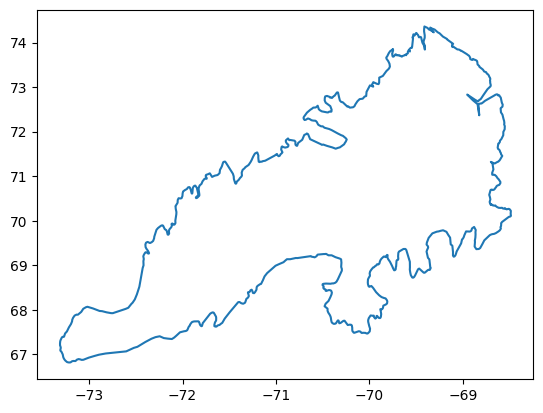

In [29]:
key = 'Amery'
shelf = gpd.read_file('/raid01/mafields/tas/MODELS_filtered/ssp585/shape_files/'+key+'.shp') 
shelf.crs = "EPSG:3031"
shelf = shelf.to_crs(epsg=4326)

shelf_lon = getPolyCoords(shelf.loc[0], 'geometry', 'x')

shelf_lon = np.array(shelf_lon)

#shelf_lon_conversion_east = shelf_lon - 360*((shelf_lon)-np.abs(shelf_lon))/(2*np.abs(shelf_lon)) (Required for Ross East and West)

shelf_lat_east = getPolyCoords(shelf.loc[0], 'geometry', 'y')
shelf_list = np.vstack([shelf_lat_east,shelf_lon]).T
shelf_path = Path(shelf_list)

plt.plot(shelf_lat_east,shelf_lon)

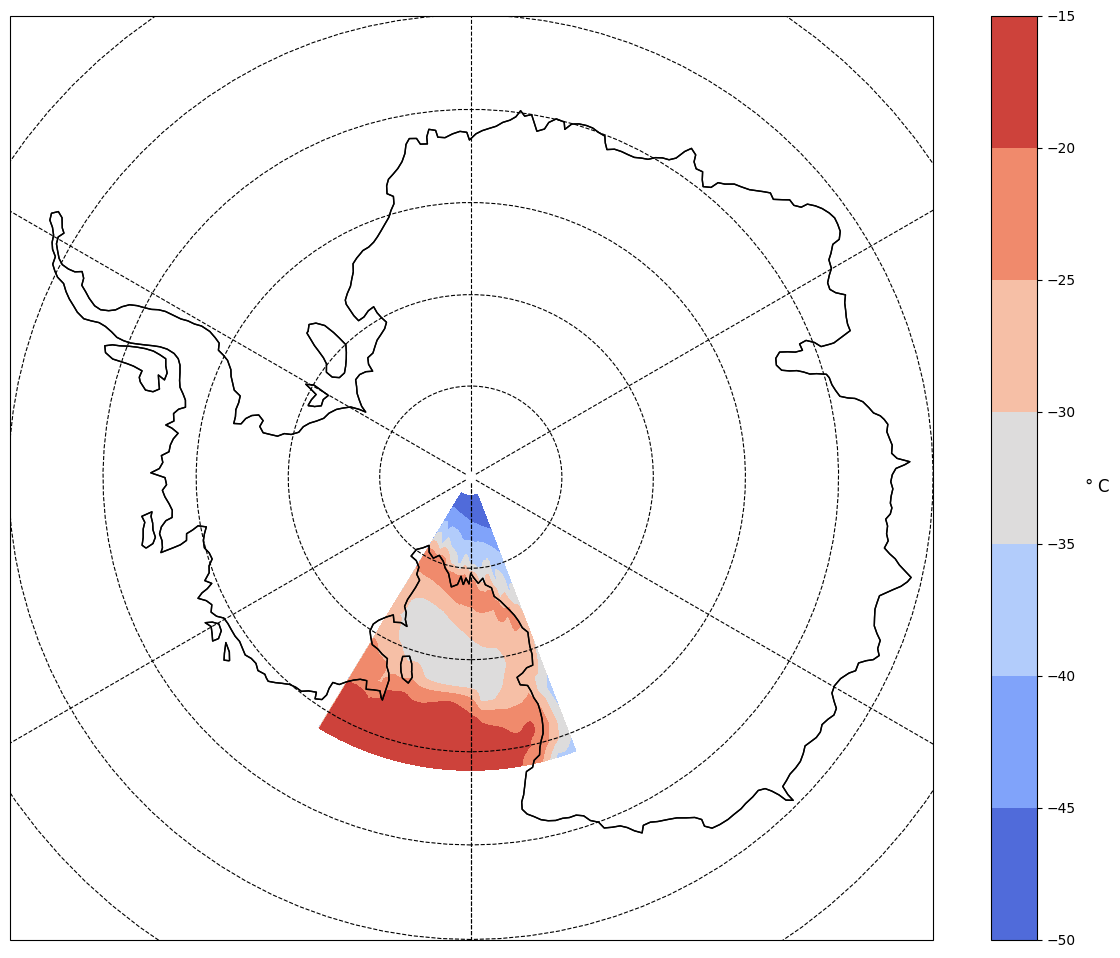

In [6]:
path = '/raid01/mafields/tas/MODELS_filtered/ssp585/iceshelves/ross/yearly/'


temp = list()
latitude = list()
longitude = list()

for path in glob.iglob(f'{path}/*.nc'): #iterating through files in path specified
        
        #Reading in Datafiles
        fname = path
        datain = Dataset(fname, 'r')
        
        #Creating Variables
        var = datain.variables['tas'] #2meter surface temperture
        lat = datain.variables['latitude'][:] #latitude
        lon = datain.variables['longitude'][:] #longitude
        timevar = datain.variables['time'] #in days since 1850
        dtime = num2date(timevar[:],timevar.units) # The next two lines make the time variable readable
        ym = np.zeros((len(dtime),2), int)
        
        temp_c = var[0,:,:] - 273.15 #converting the temperature from Kelvin to Celsius
        temp.append(temp_c)
        latitude.append(lat)
        longitude.append(lon)

temp = np.mean(temp[:],axis=0)
latitude = np.mean(latitude[:],axis=0)
longitude = np.mean(longitude[:],axis=0)

fig = plt.figure(figsize=(15,12))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.set_global()
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black', dms=True, x_inline=False, y_inline=False)
ax.coastlines(resolution="110m",linewidth=1)
ax.set_extent([-180,180, -90, -65],ccrs.PlateCarree())

data_pl = temp

lat_pl = latitude
lon_pl = longitude

data_pl,lon_pl = add_cyclic_point(temp_c,coord=longitude)

plt.contourf(lon_pl,lat_pl,data_pl,transform=ccrs.PlateCarree(),cmap='coolwarm')
cb = plt.colorbar(ax=ax, orientation="vertical")
cb.set_label(r'$\degree$ C',size=12,rotation=0,labelpad=15)
cb.ax.tick_params(labelsize=10)
    

In [7]:
with open('/raid01/mafields/tas/MODELS_filtered/ssp585/jupyter/saved_data/yearly_shelves.pkl', 'rb') as f:
    yearly_shelves = pickle.load(f)

In [10]:
def min_and_max_finder(dictionary,model_number):
    max_list = list()
    min_list = list() 
    
    for key in dictionary:
        temp_max_list = list()
        temp_min_list = list()
        for i in range(len(dictionary[key]['cropped temp'][model_number])):
            max_temp = np.max(dictionary[key]['cropped temp'][model_number][i])
            temp_max_list.append(max_temp)
            min_temp = np.min(dictionary[key]['cropped temp'][model_number][i])
            temp_min_list.append(min_temp)

        max_list.append(np.max(temp_max_list))
        min_list.append(np.min(temp_min_list))
        
    return max_list,min_list
    
    


In [11]:
max_list,min_list = min_and_max_finder(yearly_shelves,0)

In [12]:
shelf_df = yearly_shelves['Abbot']
temp = np.zeros((len(shelf_df['cropped temp'][0]),len(shelf_df['cropped temp'][0][0])))
for i in range(len(shelf_df['cropped temp'][0])):
    temp[i] = shelf_df['cropped temp'][0][i] #2meter surface temperture

print(shelf_df['cropped temp'][15][0].shape)
print(np.mean(temp, axis = 0).shape)

(143,)
(143,)


In [18]:
def plotting_iceshelf(dictionary,n):    
    
    max_list,min_list = min_and_max_finder(dictionary,n)
    
    fig = plt.figure(figsize=(15,12))
    ax = plt.axes(projection=ccrs.SouthPolarStereo())
    ax.set_global()
    ax.coastlines(resolution="110m",linewidth=1)
    ax.gridlines(linestyle='--',color='black', dms=True, x_inline=False, y_inline=False)
    ax.coastlines(resolution="110m",linewidth=1)
    ax.set_extent([-180,180, -90, -65],ccrs.PlateCarree())
    
    vmin=np.min(min_list)
    vmax=np.max(max_list)
    
    clevs = np.arange(np.floor(vmin).astype('int'),np.ceil(vmax).astype('int'),3)
    
    for key in dictionary: 
        
        shelf_df = dictionary[key]
        
        Model_name = shelf_df['Model'][n]
        
        temp = np.zeros((len(shelf_df['cropped temp'][n]),len(shelf_df['cropped temp'][n][0])))
        for i in range(len(shelf_df['cropped temp'][n])):
            temp[i] = shelf_df['cropped temp'][n][i]
            
        
        var = np.mean(temp, axis = 0) #2meter surface temperture
        lat = shelf_df['cropped lat'][n] #latitude
        lon = shelf_df['cropped lon'][n] #longitude

        data_pl = var

        lat_pl = lat
        lon_pl = lon

        plt.tricontourf(lon_pl,lat_pl,data_pl,clevs,transform=ccrs.PlateCarree(),cmap='coolwarm')
        
    cb = plt.colorbar(ax=ax, orientation="vertical")
    cb.set_label(Model_name + r' $\degree$ C',size=12,rotation=90,labelpad=15)  
    
    #plt.close()
    
    return fig


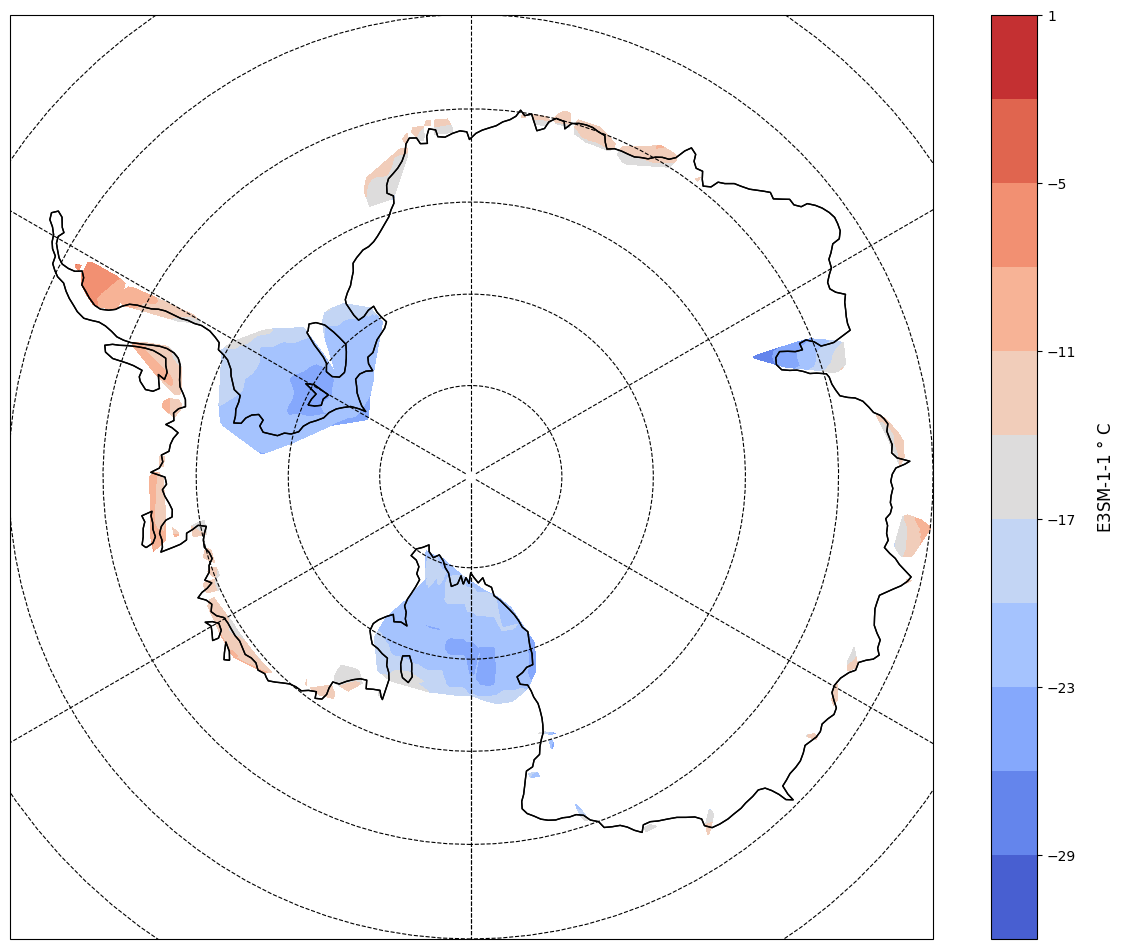

In [20]:
fig = plotting_iceshelf(yearly_shelves,0)